# Deep Learning class exercise list 1

## Question 1

* ### Generating Data

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_digits

In [5]:
def generate_data(data_size, train_val_split = 0.1):
    X = np.zeros((data_size, 3),dtype=np.float128)
    y = np.zeros((data_size, 8),dtype=np.float128)
    for i in range(data_size):
        arr = np.random.randint(0, 2, 3) + np.random.uniform(-0.1,0.1, 3)
        X[i] = np.round(arr,4)
        y[i][int(round(arr[0]) * 4 + round(arr[1]) * 2+ round(arr[2]))] = 1
    
    val_split = round(data_size * (1 - train_val_split))

    X_train, y_train = X[:val_split].T, y[:val_split].T
    X_val, y_val = X[val_split:].T, y[val_split:].T
    return X_train, X_val, y_train, y_val

* ### MLP

In [6]:
def sigmoid(value):
    return 1/(1 + np.exp(-value))

def sigmoid_derivative(value):
    return sigmoid(value) * (1 - sigmoid(value))

In [7]:
def softmax(value):
    expA = np.exp(value.T - np.max(value.T, axis=1, keepdims=True))
    return (expA / expA.sum(axis=1, keepdims=True)).T

In [8]:
def relu(value):
    return np.maximum(value, 0)

def relu_derivative(value):
    value[relu(value) <=0] = 0
    return value

## Exponentially Weighted Average
$$
V_{10} = \frac{0.1\theta_{10} + 0.9\cdot0.1\theta_{9} + 0.9^2\cdot0.1\theta_{8} + \cdots + 0.9^8\cdot0.1\theta_{2} + 0.9^9\cdot0.1\theta_{1}}{10}
$$
* This is how we usually compute an average. Although, having to keep all theses values in memory is costly. One alternative way would be to compute $V_{10}$ taking into account only $V_9$ and $\theta_{10}$.
$$
V_{10} = \frac{9}{10}V_9 + \frac{1}{10}\theta_{10}
$$

* Which can be modelled as:
$$
V_t = \beta V_{t-1} + (1 - \beta) \theta_t
$$
Where $\beta$ is calculled as $\frac{t -1}{t}$  
the time window can be calculed through having the value of $\beta$ as $\frac{1}{1 - \beta}$ days/windows

* In early training, we have to do a bias correction in this averaging, in order to compensate the lack of data in previous time steps inserted on the time window. At time step 0, if working with a 0.9 $\beta$, we will have a 
time window of 10, but our estimates will be biased and far from the real cause it will lack more terms that should make a parte of the exponentially weighted average. In order to fix this, we divide the $V$ value calculated by (1 - $\beta^t$) which will "normalize" the initial values and wont affect the values the other ones

$$
V_t = \frac{V_t}{1 - \beta^t}
$$

In [9]:
class DNN():
    def __init__(self):
        """
        Initializes your class:
            parameters : dictionary of parameters, which will store W and b through propagation.
            cache : dictionary of cache, which will be responsible for storing A and Z during the propagation.
            grads: dictionary of gradients, which will store all gradients computed during backprop.
        
        Args:
            No arguments taken.
        return:
            No return.
        """
        
        self.parameters = {}
        self.cache = {}
        self.grads = {}
        self.v = {}
        self.s = {}

    def fit(self, X_train, y_train, hidden=relu, output=softmax):
        """
        Args : 
            X_train = input data of shape (n_x, number_of_examples).
            y_train = label vector of shape (n_y, number_of_examples).
        """
        self.X_train = X_train
        self.y_train = y_train
        self.m = X_train.shape[1]
        self.hidden = hidden # function passed as argument to be used on hidden layers
        self.output = output # function passed as argument to be used on output layers

    def initialize_parameters(self, dims, adam_optimizer=False):
        """
        Args:
            dims = dimensions of the network.
            
            Example:
                dims = [3,3,8]
                
                A network with input size = 3, hidden layer = 3 and output layer = 8.
                
                The first dimension on the list must always be the length of each example.
                The last dimension on the list must always be the length of each output example.
                
                In a case where X_train shape = (3, 4500) and y_train shape = (8, 4500), 4500 in
                each shape represents the number of examples.
                
                dims = [3, 8]
        Return:
            parameters : a dictionary containing all weights and biases intialized
                
        """
        self.L = len(dims)
        for l in range(1, self.L):
            self.parameters["W" + str(l)] = np.random.randn(dims[l], dims[l-1]) * 0.01
            self.parameters["b" + str(l)] = np.zeros((dims[l], 1))
            if adam_optimizer:
                self.v["VdW" + str(l)] = np.zeros((dims[l], dims[l-1]))
                self.v["Vdb" + str(l)] = np.zeros((dims[l], 1))
                self.s["SdW" + str(l)] = np.zeros((dims[l], dims[l-1]))
                self.s["Sdb" + str(l)] = np.zeros((dims[l], 1))
        return self.parameters
    
    def propagate(self, X):
        """
        Does the forward propagation of the network
        """
        A_prev = X
        self.cache[f"A{0}"] = A_prev
        for l in range(1, self.L):
            
            Z = np.dot(self.parameters[f"W{l}"], A_prev) + self.parameters[f"b{l}"]

            if l == self.L - 1:
                A = self.output(Z)
            else:
                A = self.hidden(Z)

            self.cache[f"Z{l}"] = Z
            self.cache[f"A{l}"] = A
            
            A_prev = A
        
        self.y_hat = A

    def predict(self, X):
        """
        Predicts the value using the propagate function
        
        Args:
            X : data to be used on prediction
        Return:
            y_hat : data predicted
        """
        self.propagate(X)
        return self.y_hat
    
    def compute_cost(self):
        pred = self.y_hat.T
        real = self.y_train.T
        n_samples = real.shape[0]
        logp = - np.log(pred[np.arange(n_samples), real.argmax(axis=1)])
        cost = np.sum(logp)/(n_samples)
        return cost

    def loss(self):
        res = self.y_hat - self.y_train
        return res

    def backprop(self):
        dA = self.loss()
        
        if self.output == sigmoid:
            dZ = dA * sigmoid_derivative(self.cache[f"Z{self.L - 1}"])
        elif self.output == softmax:
            dZ = dA
        else:
            print("output activation not recognized")

        self.grads[f"dW{self.L - 1}"] = 1/self.m * (np.dot(dZ, self.cache[f"A{self.L - 2}"].T))
        self.grads[f"db{self.L - 1}"] = 1/self.m * np.sum(dZ, axis=1, keepdims=True)

        for l in reversed(range(1, self.L - 1)):
            self.grads[f"dA_prev{l}"] = np.dot(self.parameters[f"W{l + 1}"].T,dZ)
            dZ = self.grads[f"dA_prev{l}"] * relu_derivative(self.cache[f"Z{l}"])
            self.grads[f"dW{l}"] = 1/self.m * (np.dot(dZ, self.cache[f"A{l - 1}"].T))
            self.grads[f"db{l}"] = 1/self.m * np.sum(dZ, axis=1, keepdims=True)
    
    def update_grads_adam(self, t, learning_rate = 0.01, beta1 = 0.9, beta2 = 0.999, epsilon = 1e-8):
        """
        Args:
        
            beta1 : exponentially weighted average, beta = 0.9 is approx 10 days ewa
        """
        v_biasCorrected = {}
        s_biasCorrected = {}
        self.learning_rate = learning_rate
        for l in reversed(range(1, self.L)):
            # moving average of the gradients
            self.v[f"VdW{l}"] = beta1 * self.v[f"VdW{l}"] + (1 - beta1)* self.grads[f"dW{l}"]
            self.v[f"Vdb{l}"] = beta1 * self.v[f"Vdb{l}"] + (1 - beta1)* self.grads[f"db{l}"]

            v_biasCorrected[f"VdW{l}"] = self.v[f"VdW{l}"]/(1 - beta1 ** t) # bias correction to the first updates
            v_biasCorrected[f"Vdb{l}"] = self.v[f"Vdb{l}"]/(1 - beta1 ** t) # bias correction

            self.s[f"SdW{l}"] = beta2 * self.s[f"SdW{l}"] + (1 - beta2) * np.square(self.grads[f"dW{l}"])
            self.s[f"Sdb{l}"] = beta2 * self.s[f"Sdb{l}"] + (1 - beta2) * np.square(self.grads[f"db{l}"])
                                                                                             
            s_biasCorrected[f"SdW{l}"] = self.s[f"SdW{l}"]/(1 - beta2 ** t) # bias correction to the first updates
            s_biasCorrected[f"Sdb{l}"] = self.s[f"Sdb{l}"]/(1 - beta2 ** t) # bias correction
            
            self.parameters[f"W{l}"] -= self.learning_rate * (v_biasCorrected[f"VdW{l}"])/(np.sqrt(s_biasCorrected[f"SdW{l}"]) + epsilon)
            self.parameters[f"b{l}"] -= self.learning_rate * (v_biasCorrected[f"Vdb{l}"])/(np.sqrt(s_biasCorrected[f"Sdb{l}"]) + epsilon)
                                                                                               
    def update_grads_gd(self, learning_rate = 0.01):
        """
        Args:

            beta1 : exponentially weighted average, beta = 0.9 is approx 10 days ewa
        """
        self.learning_rate = learning_rate
        for l in reversed(range(1, self.L)):
            self.parameters[f"W{l}"] -= self.learning_rate * (self.grads[f"dW{l}"])
            self.parameters[f"b{l}"] -= self.learning_rate * (self.grads[f"db{l}"])

    def train(self, dims, learning_rate = 0.01, iterations = 1000, adam_optimizer=False):
        printing_interval = round(iterations * 0.01)
        self.initialize_parameters(dims, adam_optimizer=adam_optimizer)
        costs = []
        for i in range(iterations):
            self.propagate(self.X_train)
            cost = self.compute_cost()
            if i % printing_interval == 0:
                print(f"epoch {i} : {cost}")
            costs.append(cost)
            self.backprop()
            if adam_optimizer:
                self.update_grads_adam(t=i+1, learning_rate=learning_rate)
            else:
                self.update_grads_gd(learning_rate = learning_rate)
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per hundreds)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

In [10]:
X_train, X_val , y_train, y_val = generate_data(5000)

In [11]:
neural_network = DNN()

In [12]:
neural_network.fit(X_train, y_train)

epoch 0 : 2.079378997026494
epoch 1 : 2.0634085099998627
epoch 2 : 2.0269471044285474
epoch 3 : 1.9783905668382245
epoch 4 : 1.906547192523324
epoch 5 : 1.8251136918501247
epoch 6 : 1.7337501638656416
epoch 7 : 1.6242553708621703
epoch 8 : 1.4946937545374974
epoch 9 : 1.3592004315190338
epoch 10 : 1.2262535659747207
epoch 11 : 1.0925657830476907
epoch 12 : 0.9571552053515843
epoch 13 : 0.8340876405558112
epoch 14 : 0.7325200155472833
epoch 15 : 0.6373060989403112
epoch 16 : 0.5465024988092766
epoch 17 : 0.470396478621391
epoch 18 : 0.40801532563394505
epoch 19 : 0.35185609881697805
epoch 20 : 0.30361063507080455
epoch 21 : 0.2648008285363894
epoch 22 : 0.22565604567141678
epoch 23 : 0.19236904189067672
epoch 24 : 0.1661406612643288
epoch 25 : 0.14200771381491278
epoch 26 : 0.1223330968652099
epoch 27 : 0.10667281247068897
epoch 28 : 0.09185571038456486
epoch 29 : 0.0796445435868532
epoch 30 : 0.0698767353098965
epoch 31 : 0.06130242126201424
epoch 32 : 0.05444047782673452
epoch 33 : 0.

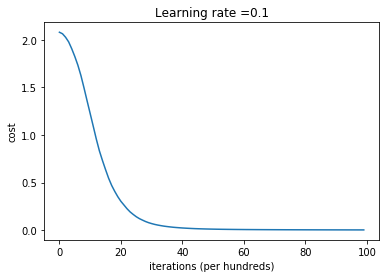

In [20]:
neural_network.train([X_train.shape[0],8, y_train.shape[0]], iterations=100, learning_rate=0.1, adam_optimizer=True)

In [21]:
y_pred = neural_network.predict(X_val)

In [22]:
np.argmax(y_pred.T, axis = 1)

array([3, 6, 7, 2, 7, 2, 1, 1, 6, 4, 0, 2, 4, 1, 4, 7, 7, 0, 7, 4, 4, 7,
       0, 6, 6, 2, 3, 7, 2, 4, 6, 0, 1, 1, 1, 4, 6, 0, 3, 1, 7, 1, 1, 4,
       2, 4, 0, 7, 1, 2, 7, 0, 0, 2, 0, 7, 5, 2, 2, 3, 7, 4, 7, 6, 5, 1,
       0, 4, 4, 0, 6, 2, 6, 4, 7, 2, 2, 4, 6, 3, 6, 5, 3, 4, 4, 1, 5, 1,
       1, 1, 6, 0, 3, 4, 4, 7, 7, 7, 2, 3, 1, 4, 6, 0, 5, 4, 1, 4, 1, 7,
       2, 1, 1, 5, 1, 2, 2, 7, 4, 1, 6, 7, 2, 0, 6, 1, 0, 4, 4, 2, 2, 3,
       4, 4, 6, 4, 1, 1, 7, 5, 1, 7, 2, 7, 7, 5, 0, 5, 4, 3, 1, 7, 6, 6,
       2, 2, 6, 5, 7, 6, 0, 3, 6, 2, 5, 3, 2, 5, 2, 5, 4, 1, 3, 0, 4, 3,
       2, 7, 7, 1, 2, 4, 3, 6, 5, 3, 0, 7, 4, 2, 7, 4, 6, 3, 2, 7, 5, 6,
       6, 5, 4, 6, 7, 7, 5, 7, 6, 5, 5, 3, 0, 5, 1, 5, 6, 5, 2, 1, 0, 1,
       0, 7, 3, 0, 2, 6, 5, 7, 5, 4, 2, 0, 2, 5, 4, 0, 2, 1, 1, 3, 6, 5,
       3, 3, 5, 5, 6, 7, 5, 3, 1, 7, 6, 2, 0, 6, 2, 0, 7, 3, 4, 6, 4, 7,
       1, 0, 3, 4, 6, 7, 0, 6, 7, 2, 0, 0, 1, 4, 5, 4, 4, 1, 7, 3, 2, 4,
       6, 7, 4, 7, 2, 2, 3, 2, 6, 6, 7, 3, 0, 0, 0,

In [23]:
np.argmax(y_val.T, axis = 1)

array([3, 6, 7, 2, 7, 2, 1, 1, 6, 4, 0, 2, 4, 1, 4, 7, 7, 0, 7, 4, 4, 7,
       0, 6, 6, 2, 3, 7, 2, 4, 6, 0, 1, 1, 1, 4, 6, 0, 3, 1, 7, 1, 1, 4,
       2, 4, 0, 7, 1, 2, 7, 0, 0, 2, 0, 7, 5, 2, 2, 3, 7, 4, 7, 6, 5, 1,
       0, 4, 4, 0, 6, 2, 6, 4, 7, 2, 2, 4, 6, 3, 6, 5, 3, 4, 4, 1, 5, 1,
       1, 1, 6, 0, 3, 4, 4, 7, 7, 7, 2, 3, 1, 4, 6, 0, 5, 4, 1, 4, 1, 7,
       2, 1, 1, 5, 1, 2, 2, 7, 4, 1, 6, 7, 2, 0, 6, 1, 0, 4, 4, 2, 2, 3,
       4, 4, 6, 4, 1, 1, 7, 5, 1, 7, 2, 7, 7, 5, 0, 5, 4, 3, 1, 7, 6, 6,
       2, 2, 6, 5, 7, 6, 0, 3, 6, 2, 5, 3, 2, 5, 2, 5, 4, 1, 3, 0, 4, 3,
       2, 7, 7, 1, 2, 4, 3, 6, 5, 3, 0, 7, 4, 2, 7, 4, 6, 3, 2, 7, 5, 6,
       6, 5, 4, 6, 7, 7, 5, 7, 6, 5, 5, 3, 0, 5, 1, 5, 6, 5, 2, 1, 0, 1,
       0, 7, 3, 0, 2, 6, 5, 7, 5, 4, 2, 0, 2, 5, 4, 0, 2, 1, 1, 3, 6, 5,
       3, 3, 5, 5, 6, 7, 5, 3, 1, 7, 6, 2, 0, 6, 2, 0, 7, 3, 4, 6, 4, 7,
       1, 0, 3, 4, 6, 7, 0, 6, 7, 2, 0, 0, 1, 4, 5, 4, 4, 1, 7, 3, 2, 4,
       6, 7, 4, 7, 2, 2, 3, 2, 6, 6, 7, 3, 0, 0, 0,

In [24]:
accuracy_score(np.argmax(y_pred.T, axis = 1), np.argmax(y_val.T, axis = 1))

1.0